In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pickle
import missingno as msno

%matplotlib inline

sns.set(color_codes = True)
pd.set_option('display.max_columns', 100)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Context
- [Package Import and Data Loading](#1)
- [Feature Engineering](#2)
- [Variable Correlation](#3)
- [Removing Outliers](#4)
- [Pickling](#5)

<a id = '1'></a>
## Loading Data

#### Data Directory
Explicitly show how opaths are indicated

In [5]:
pickle_train_dir = os.path.join('/content/drive/MyDrive/Forage/BCG-customer-churn/processed_data/client_low_missing.pkl')
pickle_history_dir = os.path.join('/content/drive/MyDrive/Forage/BCG-customer-churn/processed_data/history_price.pkl')

### Load data into dataframes
Data file are in csv format, hence we can use the built in functions in pandas

In [6]:
history_data = pd.read_pickle(pickle_history_dir)
train = pd.read_pickle(pickle_train_dir)

In [7]:
history_data.head()

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [8]:
train.head()

,id,activity_new,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,2012-11-07,2015-11-09,26520.30,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
2,d29c2c54acc38ff3c0614d0a653813dd,NaN,NaN,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
3,764c75f661154dac3a6c254cd082ea7d,NaN,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
4,bba03439a292a1e166f80264c16191cb,NaN,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0


<a id = '2'> </a>
## Feature Engineering
Since we have the consumption data for each of the companies for the year 2015, we will create new features using the `average` of the year, the last six months, and the three months to our model

In [9]:
mean_year = history_data.groupby(['id']).mean().reset_index()
mean_6m = history_data[history_data['price_date'] > '2015-06-01'].groupby(['id']).mean().reset_index()
mean_3m = history_data[history_data['price_date'] > '2015-10-01'].groupby(['id']).mean().reset_index()


In [10]:
mean_year = mean_year.rename(index=str, columns={"price_p1_var": "mean_year_price_p1_var",
 "price_p2_var": "mean_year_price_p2_var",
"price_p3_var": "mean_year_price_p3_var",
"price_p1_fix": "mean_year_price_p1_fix",
"price_p2_fix": "mean_year_price_p2_fix",
"price_p3_fix": "mean_year_price_p3_fix",})
mean_year["mean_year_price_p1"] = mean_year["mean_year_price_p1_var"] + mean_year["mean_year_price_p1_fix"]
mean_year["mean_year_price_p2"] = mean_year["mean_year_price_p2_var"] + mean_year["mean_year_price_p2_fix"]
mean_year["mean_year_price_p3"] = mean_year["mean_year_price_p3_var"] + mean_year["mean_year_price_p3_fix"]

In [11]:
mean_6m = mean_6m.rename(index=str, columns={"price_p1_var": "mean_6m_price_p1_var",
 "price_p2_var": "mean_6m_price_p2_var",
"price_p3_var": "mean_6m_price_p3_var",
"price_p1_fix": "mean_6m_price_p1_fix",
"price_p2_fix": "mean_6m_price_p2_fix",
"price_p3_fix": "mean_6m_price_p3_fix",})
mean_6m["mean_6m_price_p1"] = mean_6m["mean_6m_price_p1_var"] + mean_6m["mean_6m_price_p1_fix"]
mean_6m["mean_6m_price_p2"] = mean_6m["mean_6m_price_p2_var"] + mean_6m["mean_6m_price_p2_fix"]
mean_6m["mean_6m_price_p3"] = mean_6m["mean_6m_price_p3_var"] + mean_6m["mean_6m_price_p3_fix"]

In [12]:
mean_3m = mean_3m.rename(index=str, columns={"price_p1_var": "mean_3m_price_p1_var",
 "price_p2_var": "mean_3m_price_p2_var",
"price_p3_var": "mean_3m_price_p3_var",
"price_p1_fix": "mean_3m_price_p1_fix",
"price_p2_fix": "mean_3m_price_p2_fix",
"price_p3_fix": "mean_3m_price_p3_fix",})
mean_3m["mean_3m_price_p1"] = mean_3m["mean_3m_price_p1_var"] + mean_3m["mean_3m_price_p1_fix"]
mean_3m["mean_3m_price_p2"] = mean_3m["mean_3m_price_p2_var"] + mean_3m["mean_3m_price_p2_fix"]
mean_3m["mean_3m_price_p3"] = mean_3m["mean_3m_price_p3_var"] + mean_3m["mean_3m_price_p3_fix"]

In [13]:
features = mean_year

### Feature Engineering
In the previous nootebook, we explore the data and made a deep dive into the churn by dates. Nonetheless, that exploration was quite shallow and did not provide us with any relevant insight.

What if we could create a new variable that could provide us more relevant insights?
> We will define a variable <code> tenure = date_end - date_activ </code>

In [14]:
train.head(2)

,id,activity_new,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,2012-11-07,2015-11-09,26520.3,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1


In [15]:
train['tenure'] = ((train['date_end'] - train['date_activ'])/np.timedelta64(1, 'Y')).astype(int)

In [16]:
tenure = train[['id', 'tenure', 'churn']].groupby(['tenure', 'churn'])['id'].count().unstack(level = 1).fillna(0)
tenure_percentage = (tenure.div(tenure.sum(axis = 1), axis = 0)* 100)

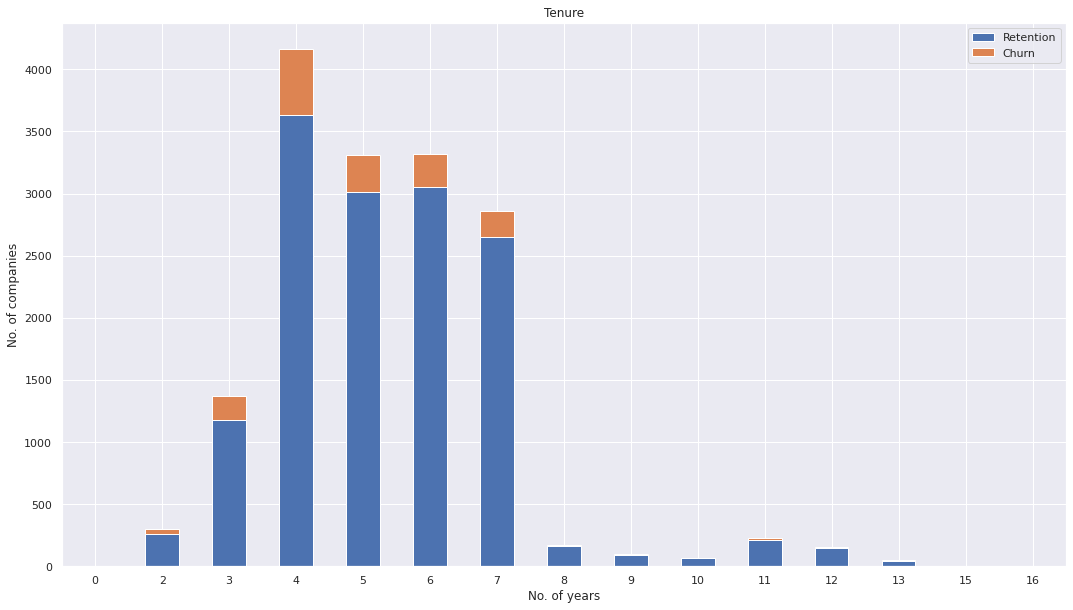

In [17]:
tenure.plot(kind = 'bar', 
            figsize = (18, 10),
            stacked = True,
            rot = 0,
            title = 'Tenure');
plt.legend(['Retention', 'Churn'], loc = 'upper right')
plt.ylabel('No. of companies')
plt.xlabel('No. of years')
plt.show();

We can clearly see that churn is very low for companies which joined recently or that have made the contract a long time ago. With the higher number of churners within the 3-7 years of tenure.<br>
We will also transform the dates provided insuch a way that we can make more sense out of those. 
> `months_activ`: Number of months active until reference date (Jan 2016)

> `months_to_end`: Number of months of the contact left at reference date (Jan 2016)

> `months_modif_prod`: Number of months since last modification at reference date (Jan 2016)

> `months_renewal`: Number of months since last renewal at reference date (Jan 2016)

To create the month column we will follow a simple process:
1. Substract the reference date and the column date
2. Convert the timedelta in months
3. Convert to interger (we are not interested in having decimal months)

In [18]:
def convert_months(reference_date, dataframe, column):
    '''
    Input a column with timedeltas and return months
    '''
    time_delta = REFERENCE_DATE - dataframe[column]
    months = (time_delta/np.timedelta64(1, 'M')).astype(int)
    return months

In [19]:
REFERENCE_DATE = datetime.datetime(2016, 1, 1)

In [20]:
train["months_activ"] = convert_months(REFERENCE_DATE, train, "date_activ")
train["months_to_end"] = -convert_months(REFERENCE_DATE, train, "date_end")
train["months_modif_prod"] = convert_months(REFERENCE_DATE, train, "date_modif_prod")
train["months_renewal"] = convert_months(REFERENCE_DATE, train, "date_renewal")

Let's see if we can get any insights

In [21]:
def plot_churn_by_month(dataframe, column, fontsize_ = 11, rot_ = 0):
    '''
    Plot churn distribution by monthly variable
    '''
    temp = dataframe[[column, 'churn', 'id']].groupby([column, 'churn'])['id'].count().unstack(level = 1)
    temp.plot(kind = 'bar',
             figsize = (30, 15),
             stacked = True,
             rot = rot_,
             title = column);
    # rename legend
    plt.legend(['Retention', 'Churn'], loc = 'upper right')
    # Labels
    plt.ylabel('No. of companies')
    plt.xlabel('No. of months')
    plt.xticks(fontsize = fontsize_)
    plt.show();

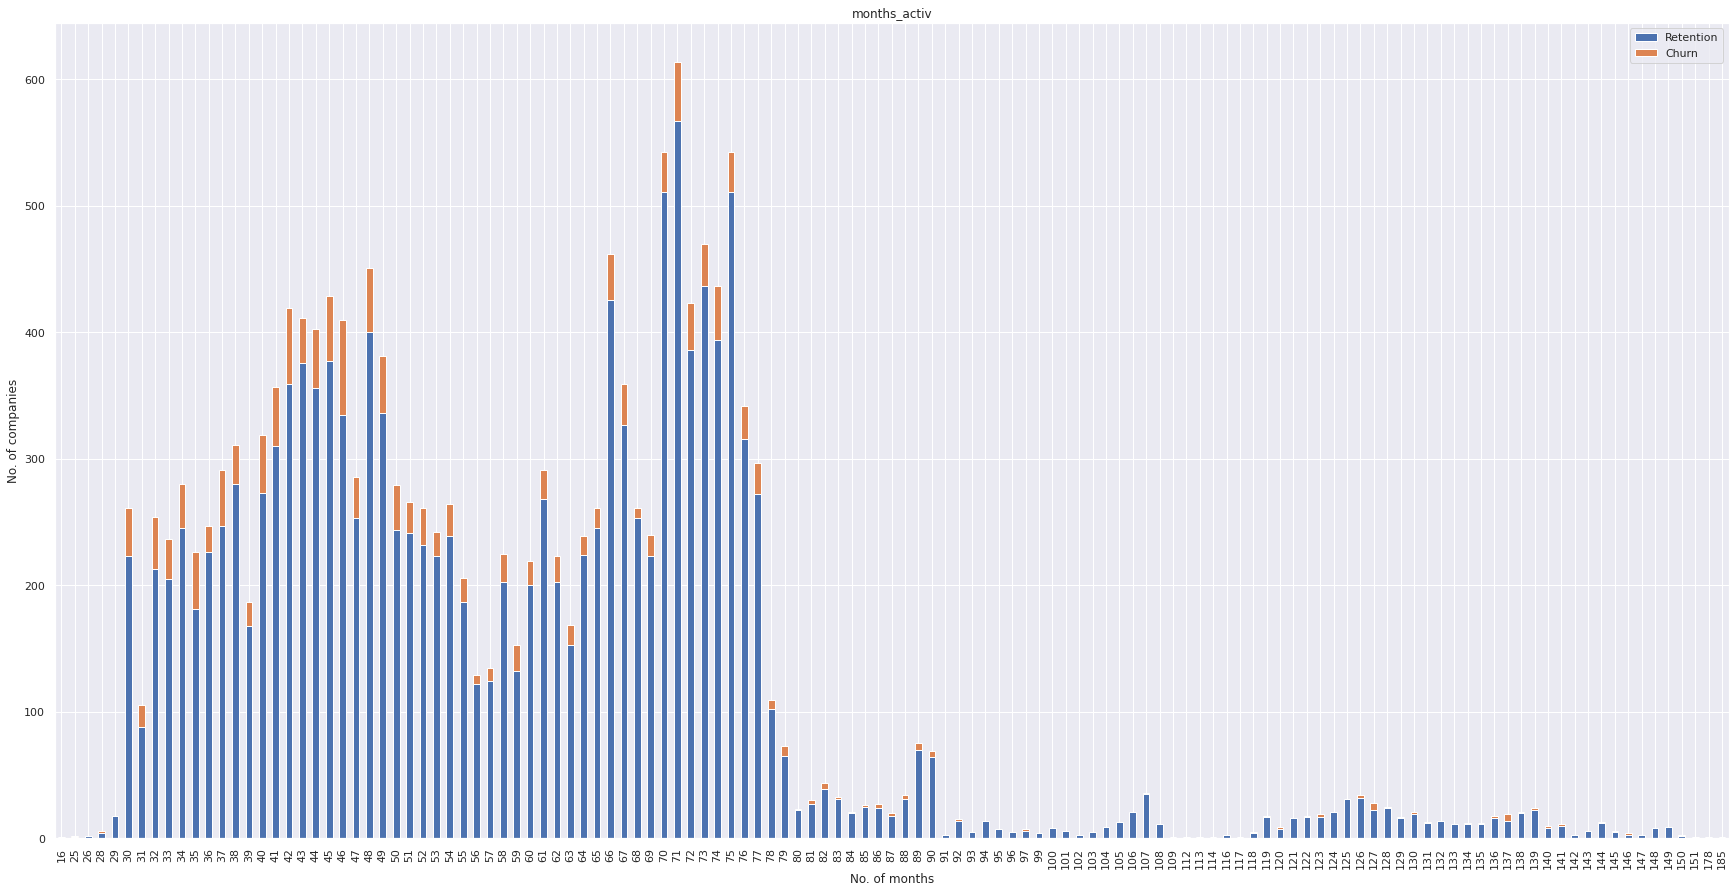

In [22]:
plot_churn_by_month(train, 'months_activ', rot_ = 90)


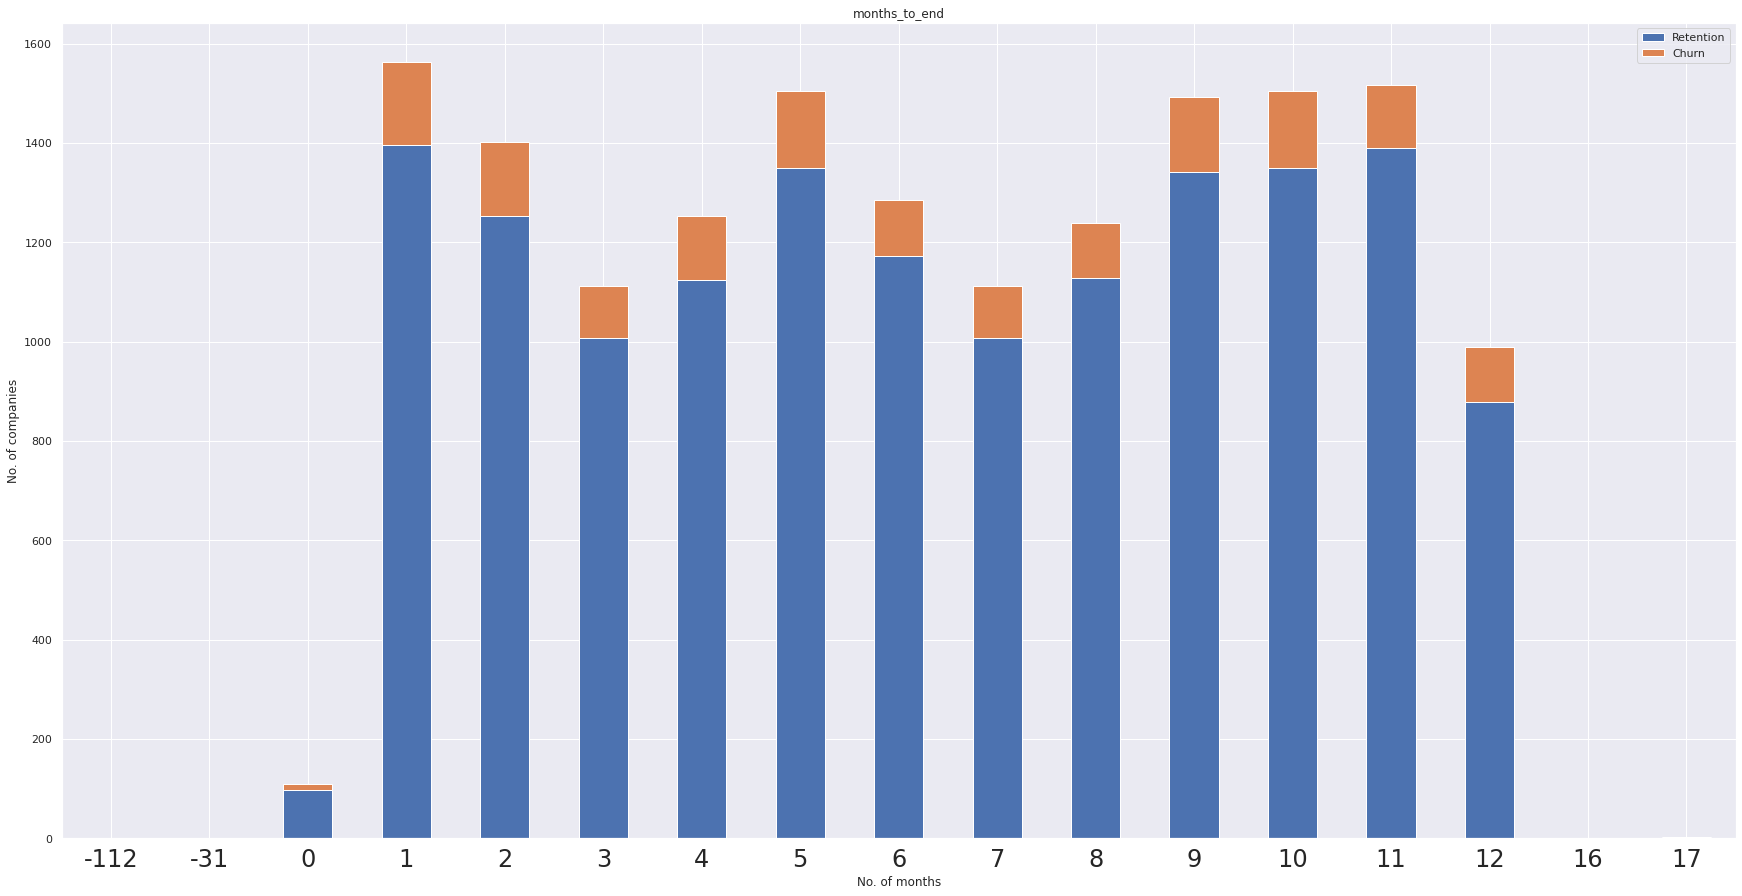

In [23]:
plot_churn_by_month(train, 'months_to_end', 24)

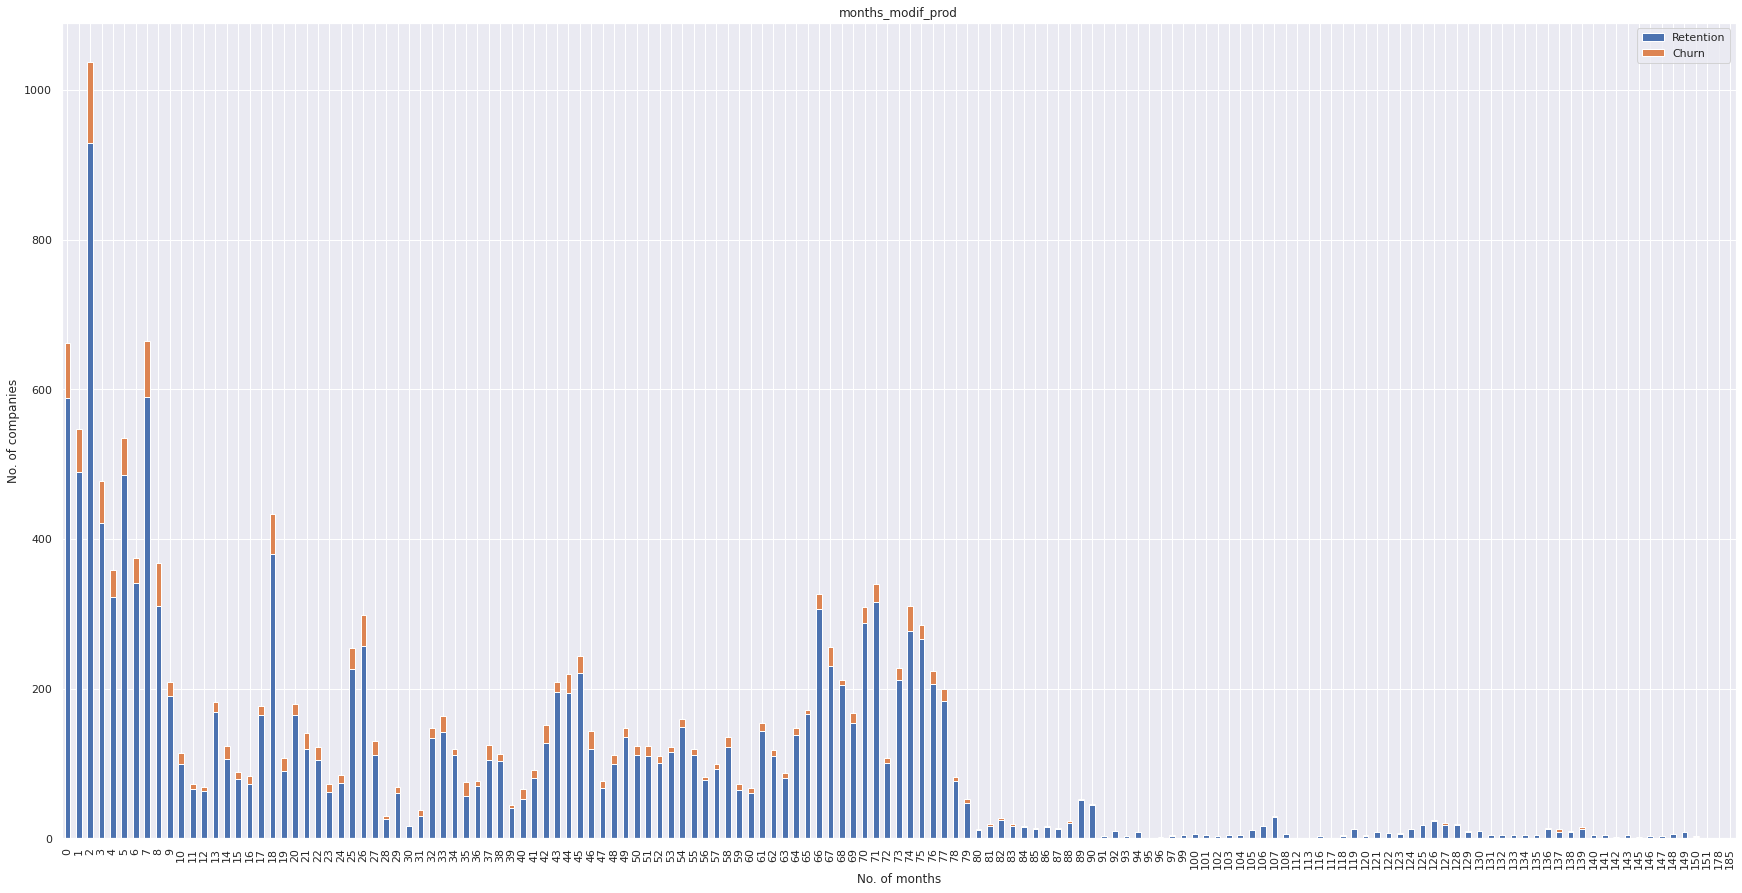

In [24]:
plot_churn_by_month(train, 'months_modif_prod', rot_ = 90)

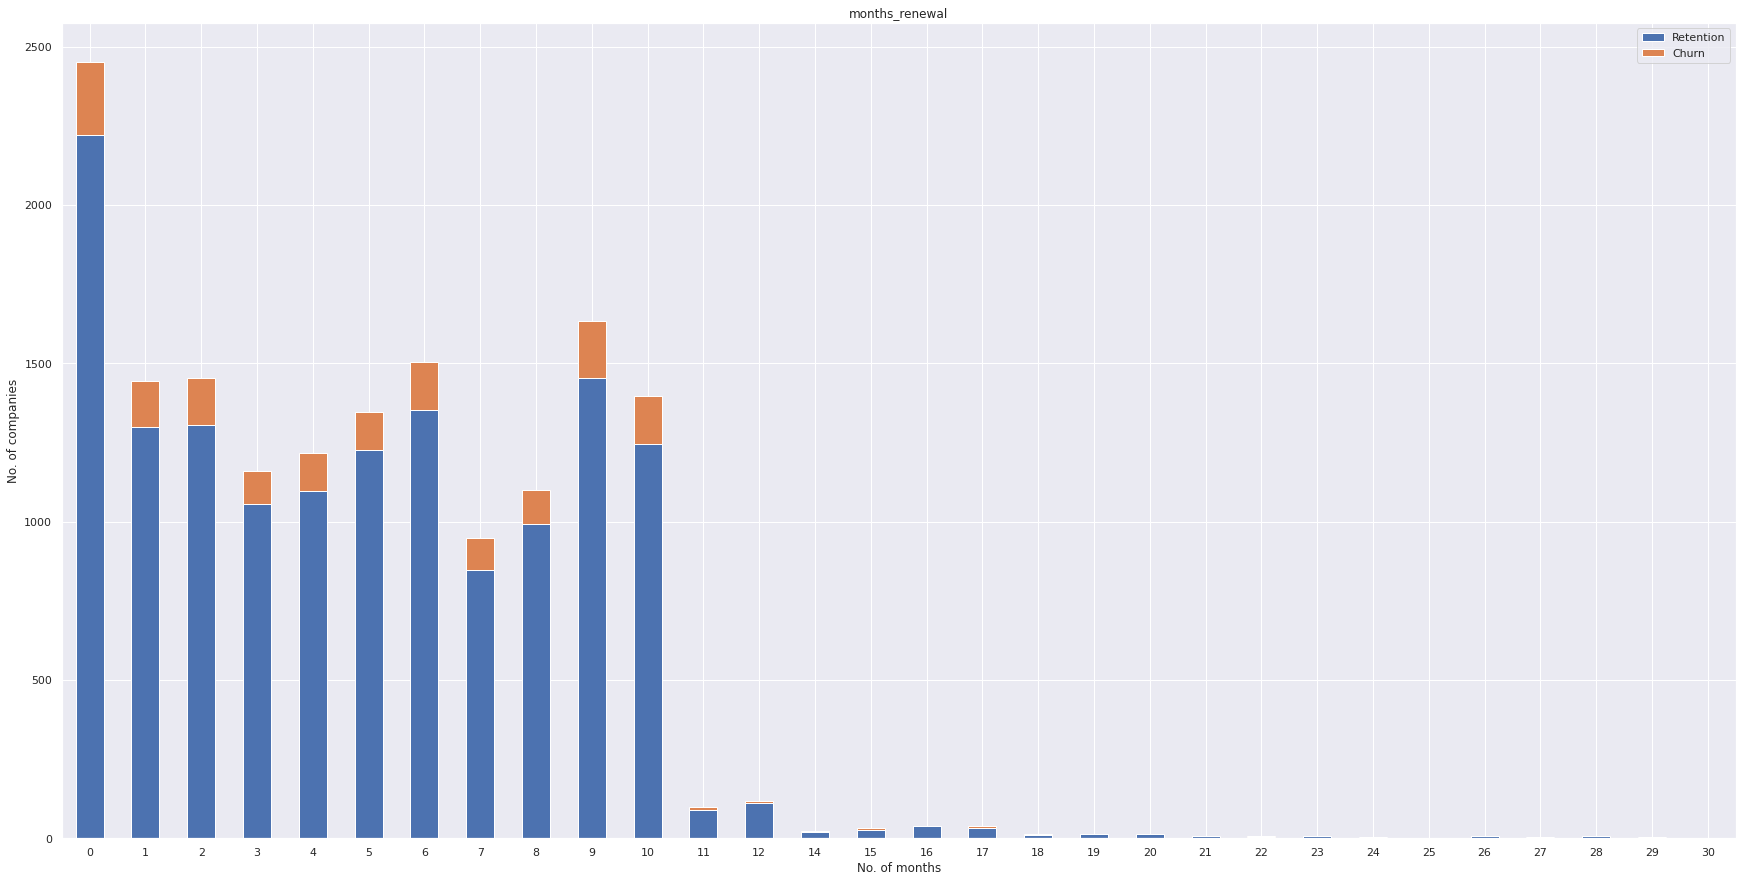

In [25]:
plot_churn_by_month(train, 'months_renewal')

Remove the date columns

In [26]:
train = train.drop(columns = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'])


### Transforming boolean data
For the column has_gas, we will replace t for True or 1, and f for False or 0. This process is usually referred as `onehot` encoding

In [27]:
train['has_gas'] = train['has_gas'].replace(['t', 'f'], [1, 0])

### Categorical data and dummy variables
When training our model we cannot use `string` data as such, so we will need to encode it into numerical data. The easiest method is mapping each category to an integer (label encoding) but this will not work because the model will misunderstand the data to be in some kind of order or hierarchy. 
For that reason we will use a method with `dummy` variables or `onehot` encoder

- activity_new
- channel_sales
- origin_up

**Categorical data `channel_sales`**<br>
What we are doing here relatively simple, we want to convert each category into a new dummy `variable` which will have 0s and 1s depending wheather than entry belongs to that particular category or not.

First of all let's replace the `Nan` values with a string called `null_values_channel`

In [28]:
train['channel_sales'] = train['channel_sales'].fillna('null_channel_sales').astype('category')
pd.DataFrame({'samples_in_category': train['channel_sales'].value_counts()})

,samples_in_category
foosdfpfkusacimwkcsosbicdxkicaua,7377
null_channel_sales,4218
lmkebamcaaclubfxadlmueccxoimlema,2073
usilxuppasemubllopkaafesmlibmsdf,1444
ewpakwlliwisiwduibdlfmalxowmwpci,966
sddiedcslfslkckwlfkdpoeeailfpeds,12
epumfxlbckeskwekxbiuasklxalciiuu,4
fixdbufsefwooaasfcxdxadsiekoceaa,2


In [29]:
# create dummy variables
categories_channel = pd.get_dummies(train['channel_sales'], prefix = 'channel')

In [30]:
# rename column name for simplicity
categories_channel.columns = [col_name[: 11] for col_name in categories_channel.columns]

We will explain the concept of `multicollinearity` in the next section. Simply put, multicollinearity is when two or more independent variables in a regression are highly related to one another, such that they do not provide unique or independent information to the regression.

`Multicollinearity` can affect our models so we will remove one of columns.

In [31]:
categories_channel = categories_channel.drop(columns = ['channel_nul'])

**Categorical data `origin_up`**<br>
First of all let's replace the `Nan` values with a string called `null_values_origin` Then transform the `origin_up` to categorical data type. 

In [32]:
train['origin_up'] = train['origin_up'].fillna('null_values_origin').astype('category')
pd.DataFrame({'sample_in_origin_up': train['origin_up'].value_counts()})

,sample_in_origin_up
lxidpiddsbxsbosboudacockeimpuepw,7825
kamkkxfxxuwbdslkwifmmcsiusiuosws,4517
ldkssxwpmemidmecebumciepifcamkci,3664
null_values_origin,87
usapbepcfoloekilkwsdiboslwaxobdp,2
ewxeelcelemmiwuafmddpobolfuxioce,1


In [33]:
# create dummy variables
categories_origin = pd.get_dummies(train['origin_up'], prefix = 'origin')

In [34]:
# rename column name for simplicity
categories_origin.columns = [col_name[:10] for col_name in categories_origin.columns]

In [35]:
# remove one column to avoid dummy variable
categories_origin = categories_origin.drop(columns = ['origin_nul'])

**Categorical Data `activity_new`**<br>
First of all let's replace the `Nan` values with a string called `null_values_activity`. We want to see how many categories we will end up with

As we could see below there are too many categories with very few number of samples. So we will replace any category with less than 75 samples as `null_values_categories`.

In [36]:
train['activity_new'] = train['activity_new'].fillna('null_activity_new')
categories_activity = pd.DataFrame({'sample_in_activity': train['activity_new'].value_counts()})

In [37]:
# get the categories with less than 75 samples
to_replace = list(categories_activity[categories_activity['sample_in_activity'] <= 75].index)
# replace them with `null_activity_new`
train['activity_new'] = train['activity_new'].replace(to_replace, 'null_activity_new')


In [38]:
# create dummy variables
categories_activity = pd.get_dummies(train['activity_new'], prefix = 'activity')
categories_activity.columns = [col_name[:12] for col_name in categories_activity.columns]

In [39]:
categories_activity = categories_activity.drop(columns = ['activity_nul'])
categories_activity.head()

,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0


**Merge dummy variables to main dataframe**<br>
We wil merge all the new categories into our main dataframe and remove the old categorical columns

In [40]:
train = pd.merge(train, categories_channel, left_index = True, right_index = True)
train = pd.merge(train, categories_origin, left_index = True, right_index = True)
train = pd.merge(train, categories_activity, left_index = True, right_index = True)



In [41]:
# finally remove the columns to avoid the dummy variable trap
train.drop(columns = ['channel_sales', 'activity_new', 'origin_up'], inplace = True)

### Log Transformation

Remember from the previous exercise that a lot of the variables we are dealing with are highly skewed to the right <br>
**Why is skewness relevant?** Skewness is not bad per se. Nonetheless, some predictive models make fundamental assumptions related to variables being 'normallyu distributed'. Hence, the model will perform poorly if the data is highly skewed <br>
There are several methods in which we can reduce skewness such as `square root`, `cube root`, and `log`. In this case, we will use a `log transformation` which is usually recommended for right skewed data. 

In [42]:
train.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
count,1.609600e+04,1.609600e+04,1.609600e+04,16096.000000,16096.000000,15970.000000,16096.000000,15970.000000,15970.000000,15970.000000,16096.000000,16096.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,1.948044e+05,3.191164e+04,1.946154e+04,2370.555949,1907.347229,0.991547,70.309945,0.135901,0.052951,43.533496,0.184145,196.123447,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093,5.329958,58.929858,6.376615,35.741240,4.924640,0.000249,0.060015,0.000124,0.458313,0.128790,0.000746,0.089712,0.000062,0.280629,0.227634,0.486146,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.005157,0.007393
std,6.795151e+05,1.775885e+05,8.235676e+04,4035.085664,5257.364759,5.160969,79.023251,0.026252,0.048617,5.212252,0.387615,494.366979,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796,1.749248,20.125024,3.633479,30.609746,3.812127,0.015763,0.237522,0.011147,0.498275,0.334978,0.027295,0.285777,0.007882,0.449320,0.419318,0.499824,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.071626,0.085668
min,-1.252760e+05,-3.037000e+03,-9.138600e+04,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184,0.000000,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000,0.000000,16.000000,-112.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.906250e+03,0.000000e+00,0.000000e+00,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,0.000000,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000,4.000000,44.000000,3.000000,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.533250e+04,0.000000e+00,9.010000e+02,1179.160000,378.000000,0.000000,19.440000,0.142881,0.086163,44.311378,0.000000,44.465000,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000,5.000000,57.000000,6.000000,29.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.022150e+04,0.000000e+00,4.127000e+03,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378,0.000000,218.090000,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000,6.000000,71.000000,9.000000,64.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.609711e+07,4.188440e+06,4.538720e+06,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,59.444710,1.000000,15042.790000

Particularly relevant to look at the standard devviation `std` which is bery very high for some variables.<br>
Log transformation does not work with negative data, so we will convert the negative values to `NaN`<br>
Also we cannot apply a log transformation to 0 valued entires, so we will add a constant 1

In [43]:
# remove negative values
train.loc[train.cons_12m < 0, 'cons_12m'] = np.nan
train.loc[train.cons_gas_12m < 0, 'cons_gas_12m'] = np.nan
train.loc[train.cons_last_month < 0, 'cons_last_month'] = np.nan
train.loc[train.forecast_cons_12m < 0, 'forecast_cons_12m'] = np.nan
train.loc[train.forecast_cons_year < 0, 'forecast_cons_year'] = np.nan
train.loc[train.forecast_meter_rent_12m < 0, 'forecast_meter_rent_12m'] = np.nan
train.loc[train.imp_cons < 0, 'imp_cons'] = np.nan


In [44]:
# apply log10 transformation
train['cons_12m'] = np.log10(train['cons_12m'] + 1)
train['cons_gas_12m'] = np.log10(train['cons_gas_12m'] + 1)
train['cons_last_month'] = np.log10(train['cons_last_month'] + 1)
train['forecast_cons_12m'] = np.log10(train['forecast_cons_12m'] + 1)
train['forecast_cons_year'] = np.log10(train['forecast_cons_year'] + 1)
train['forecast_meter_rent_12m'] = np.log10(train['forecast_meter_rent_12m'] + 1)
train['imp_cons'] = np.log10(train['imp_cons'] + 1)

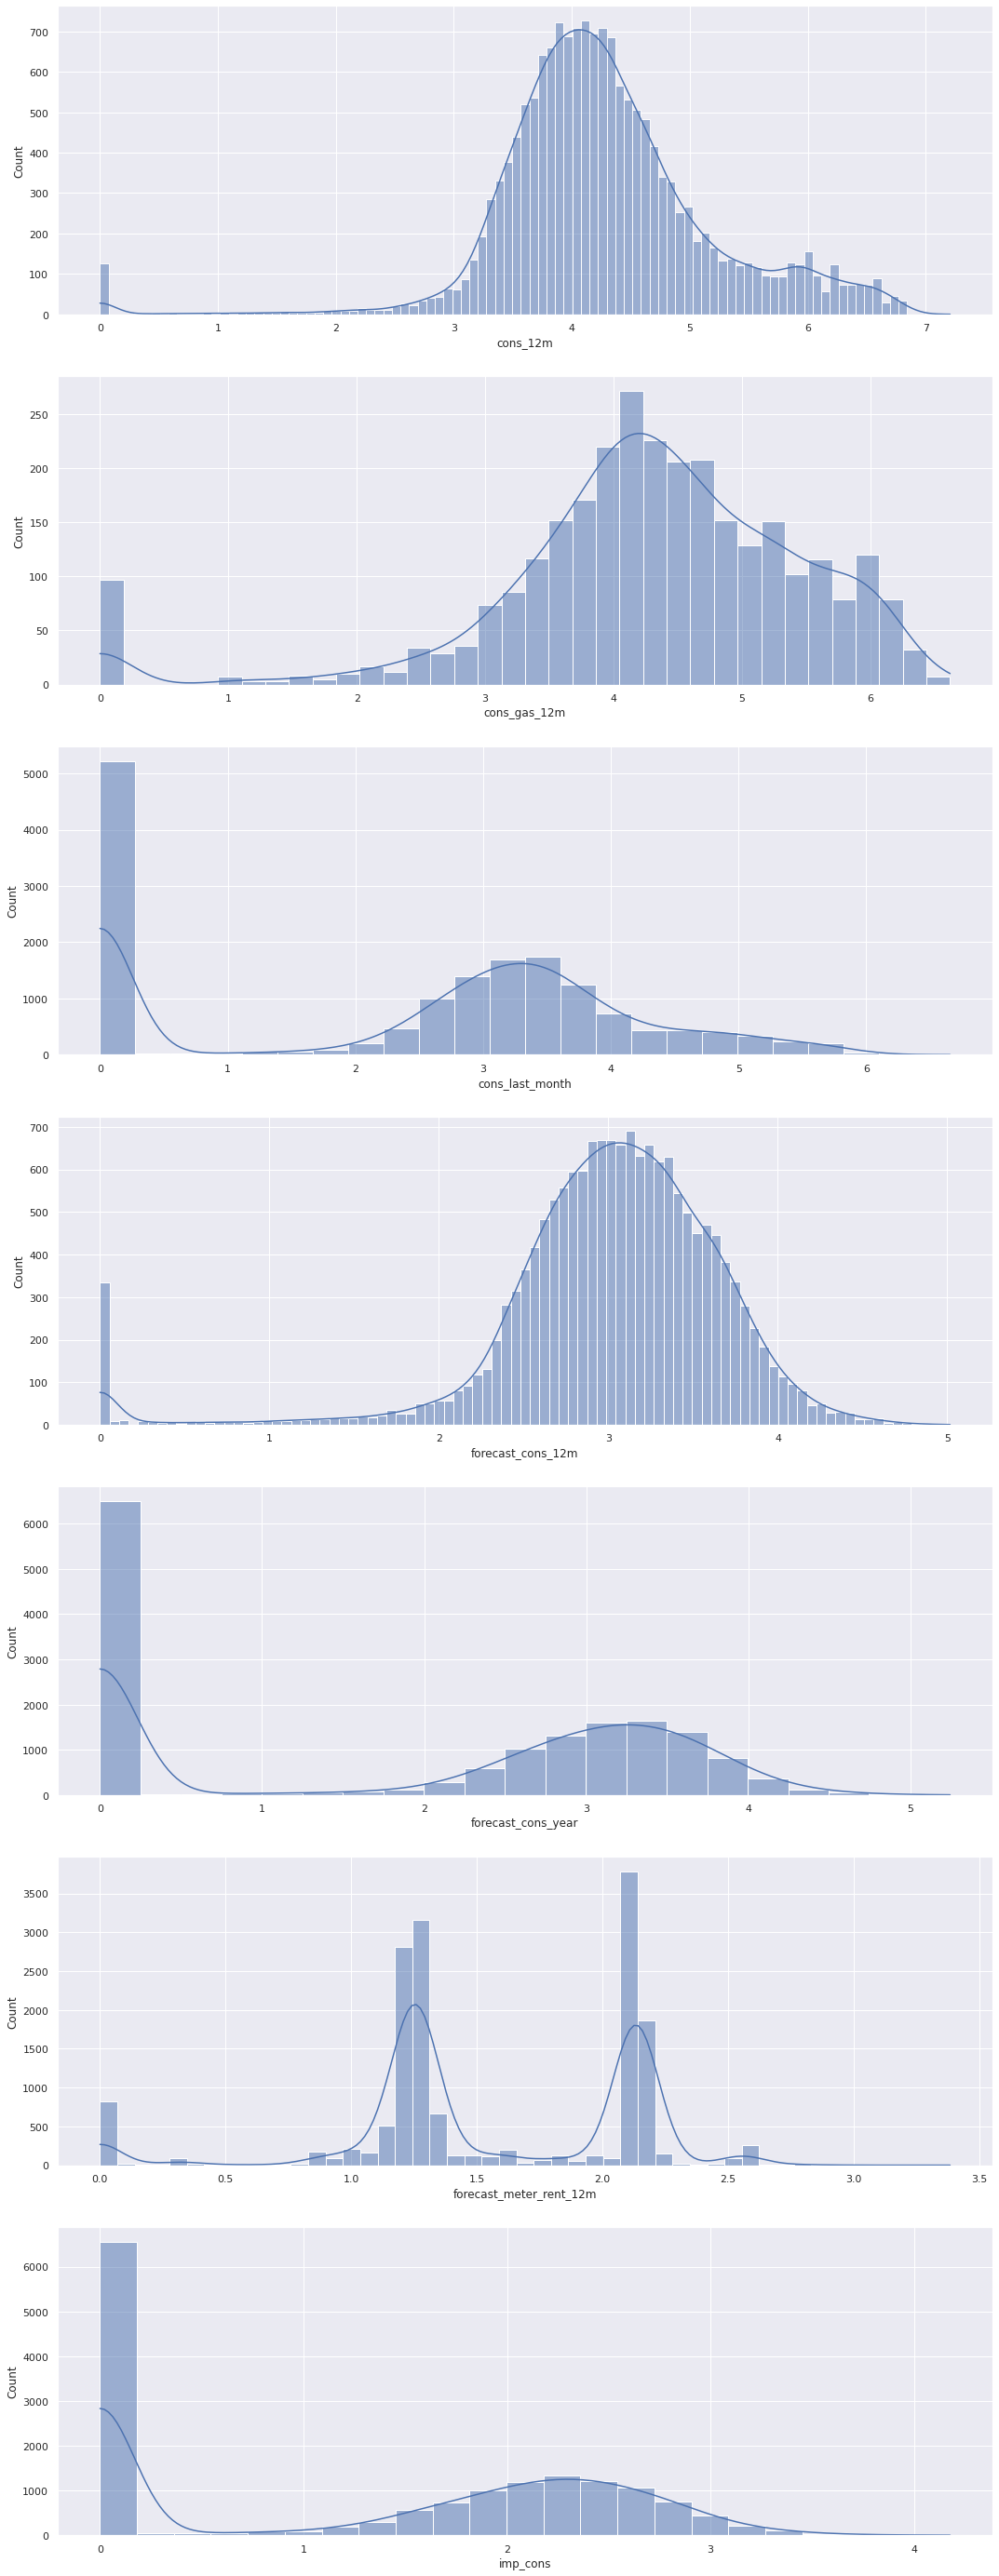

In [45]:
fig, axs = plt.subplots(nrows = 7, figsize = (18, 50));
# Plot Histogram
sns.histplot(train['cons_12m'].dropna(), ax = axs[0], kde=True);
sns.histplot(train[train['has_gas'] == 1]['cons_gas_12m'].dropna(), ax = axs[1], kde=True);
sns.histplot(train['cons_last_month'].dropna(), ax = axs[2], kde=True);
sns.histplot(train['forecast_cons_12m'].dropna(), ax = axs[3], kde=True);
sns.histplot(train['forecast_cons_year'].dropna(), ax = axs[4], kde=True);
sns.histplot(train['forecast_meter_rent_12m'].dropna(), ax = axs[5], kde=True);
sns.histplot(train['imp_cons'].dropna(), ax = axs[6], kde=True);
plt.show()

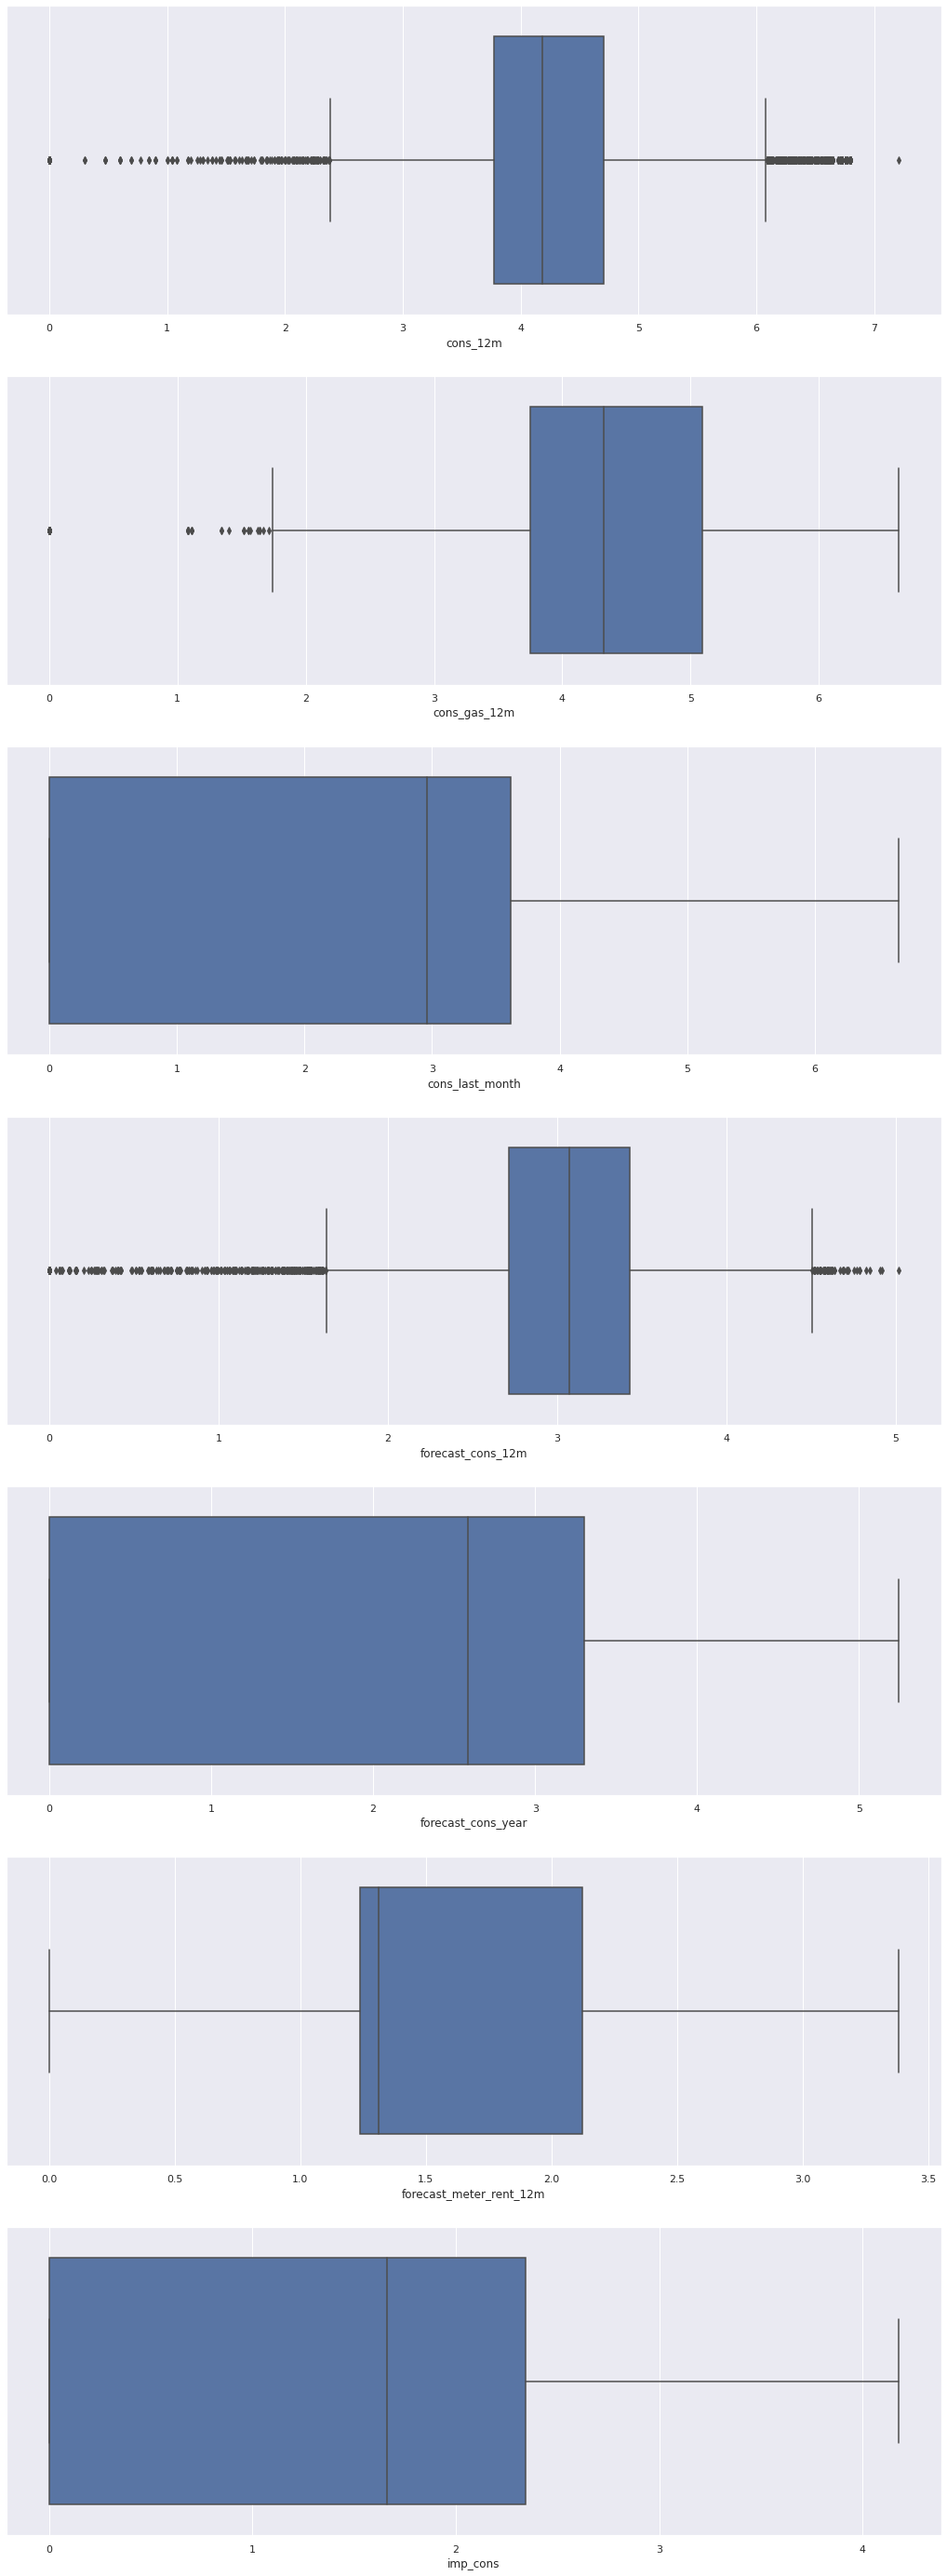

In [46]:
fig, axs = plt.subplots(nrows = 7, figsize = (18, 50));
# Plot Boxplot
sns.boxplot(x = train['cons_12m'].dropna(), ax = axs[0]);
sns.boxplot(x = train[train['has_gas'] == 1]['cons_gas_12m'].dropna(), ax = axs[1]);
sns.boxplot(x = train['cons_last_month'].dropna(), ax = axs[2]);
sns.boxplot(x = train['forecast_cons_12m'].dropna(), ax = axs[3]);
sns.boxplot(x = train['forecast_cons_year'].dropna(), ax = axs[4]);
sns.boxplot(x = train['forecast_meter_rent_12m'].dropna(), ax = axs[5]);
sns.boxplot(x = train['imp_cons'].dropna(), ax = axs[6]);
plt.show()

The distribution looks much closer to normal distributions now<br>
Notice how the standard deviation `std` has changed <br>
From the boxplots we can still see move values are quite far from the range (outliers). We will deal with them later.


## High Correlation Variables
Calculate the correlation of the variables

We can remove highly correlated variables. <br>
Multicollinearity happens when one predictor variable in a multiple regression model can be linearly predicteed from the others with a high degree of accuracy. This can lead to skewed or misleading results. Luckily, decision trees and boosted tree algorithms are immune to multicollinearity by nature, When they decide to split, the tree will choose only one of the perfectly correlated features. However, other algorithms like Logistic Regression or linear Regression are not immune to that problem and should be fixed before training the model.

As expected, `num_years_antig` has a high correlation with `months_activ`

In [47]:
# calculate correlation of variables
correlation = features.corr()

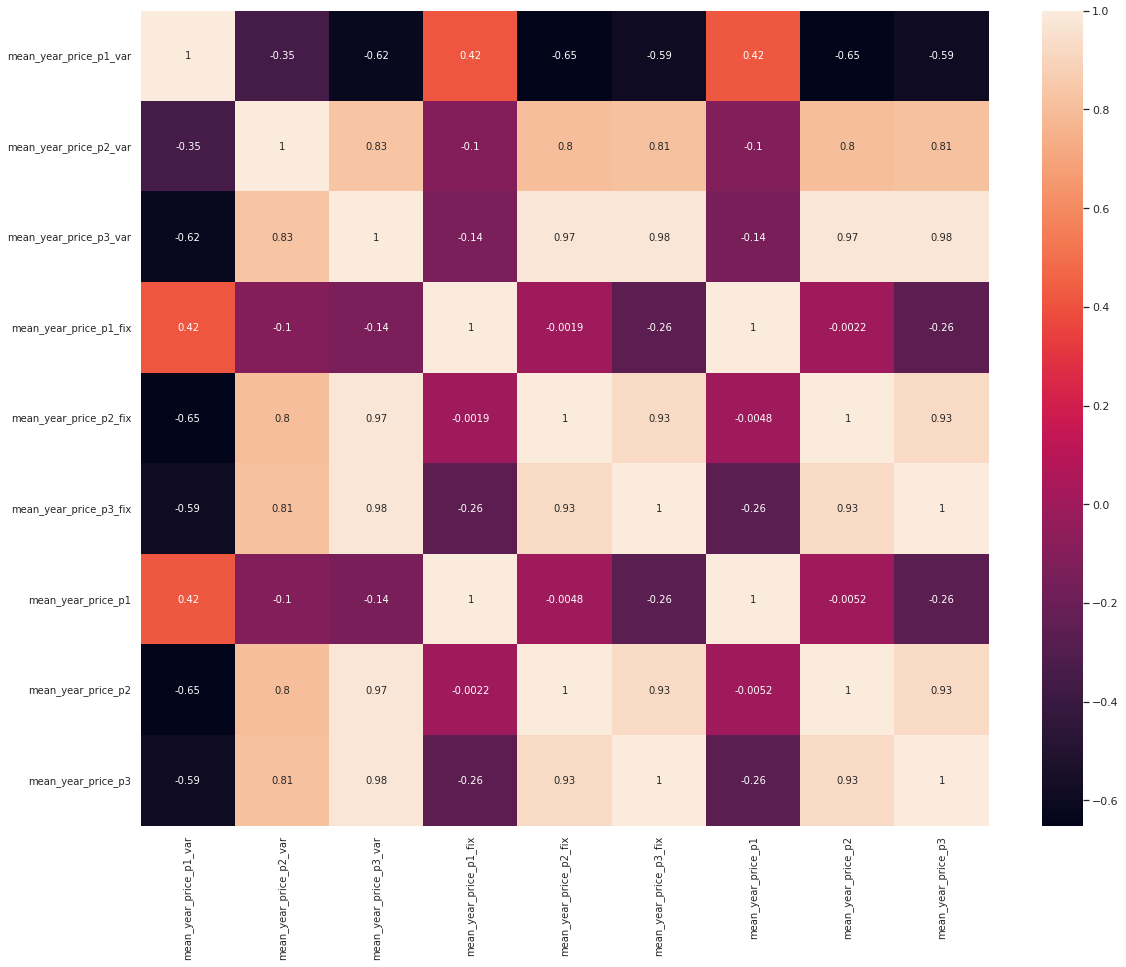

In [48]:
# Plot correlation
plt.figure(figsize = (19, 15))
sns.heatmap(correlation, 
            xticklabels = correlation.columns.values, 
           yticklabels = correlation.columns.values,
           annot = True,
           annot_kws = {'size': 10})
# Axis ticks size
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

In [49]:
# calculate correlation of variables
correlation = train.corr()

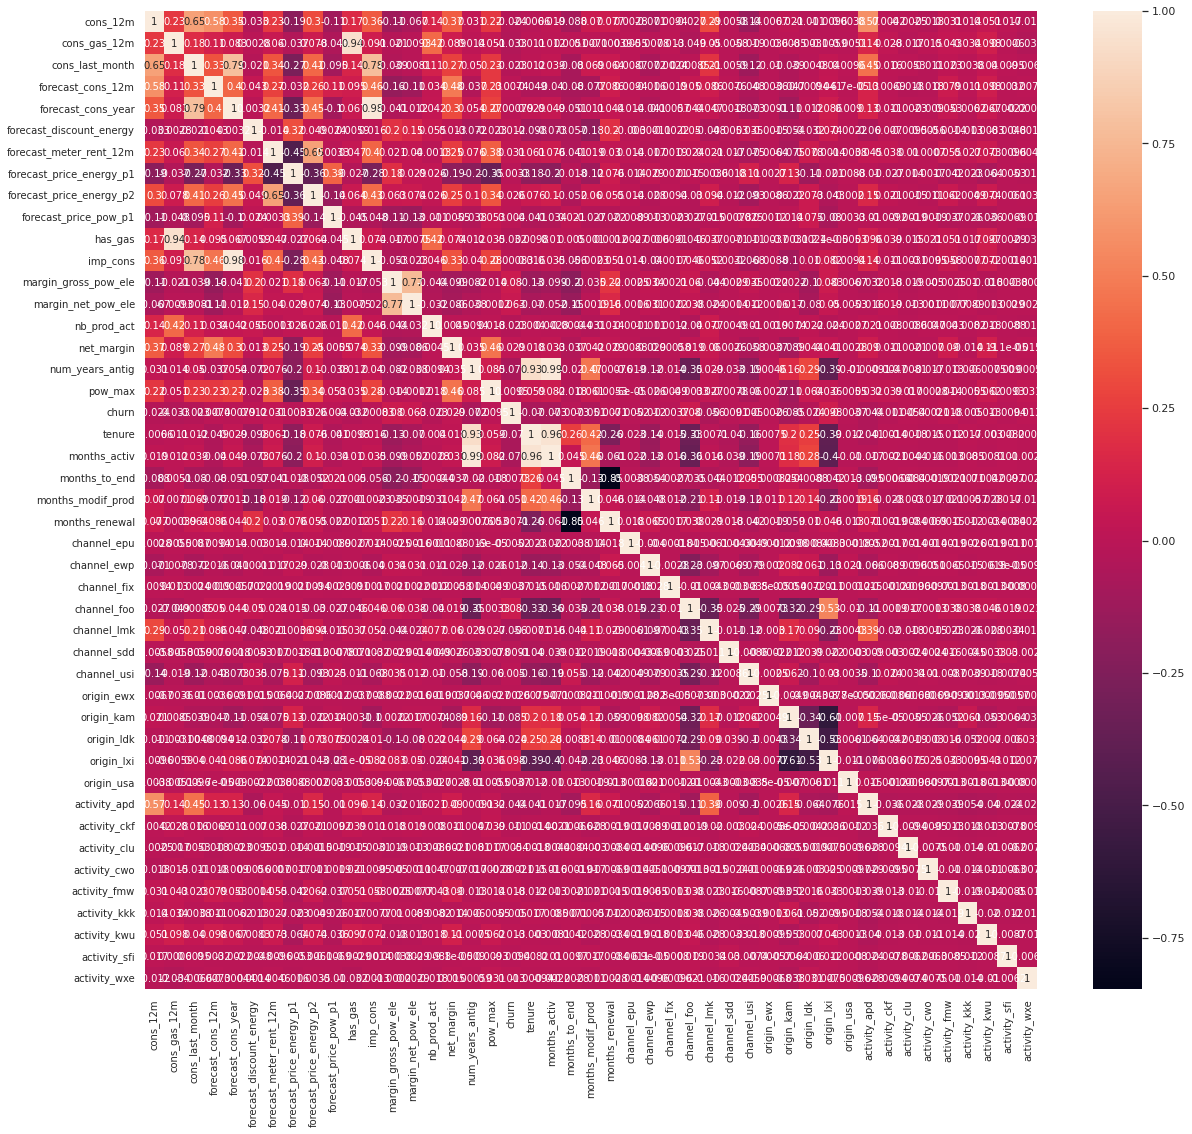

In [50]:
# Plot correlation
plt.figure(figsize = (20, 18))
sns.heatmap(correlation, 
            xticklabels = correlation.columns.values,
           yticklabels = correlation.columns.values,
           annot = True,
           annot_kws = {'size': 10})
# Axis ticks size
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

In [51]:
train.drop(columns = ['num_years_antig', 'forecast_cons_year'], inplace = True)

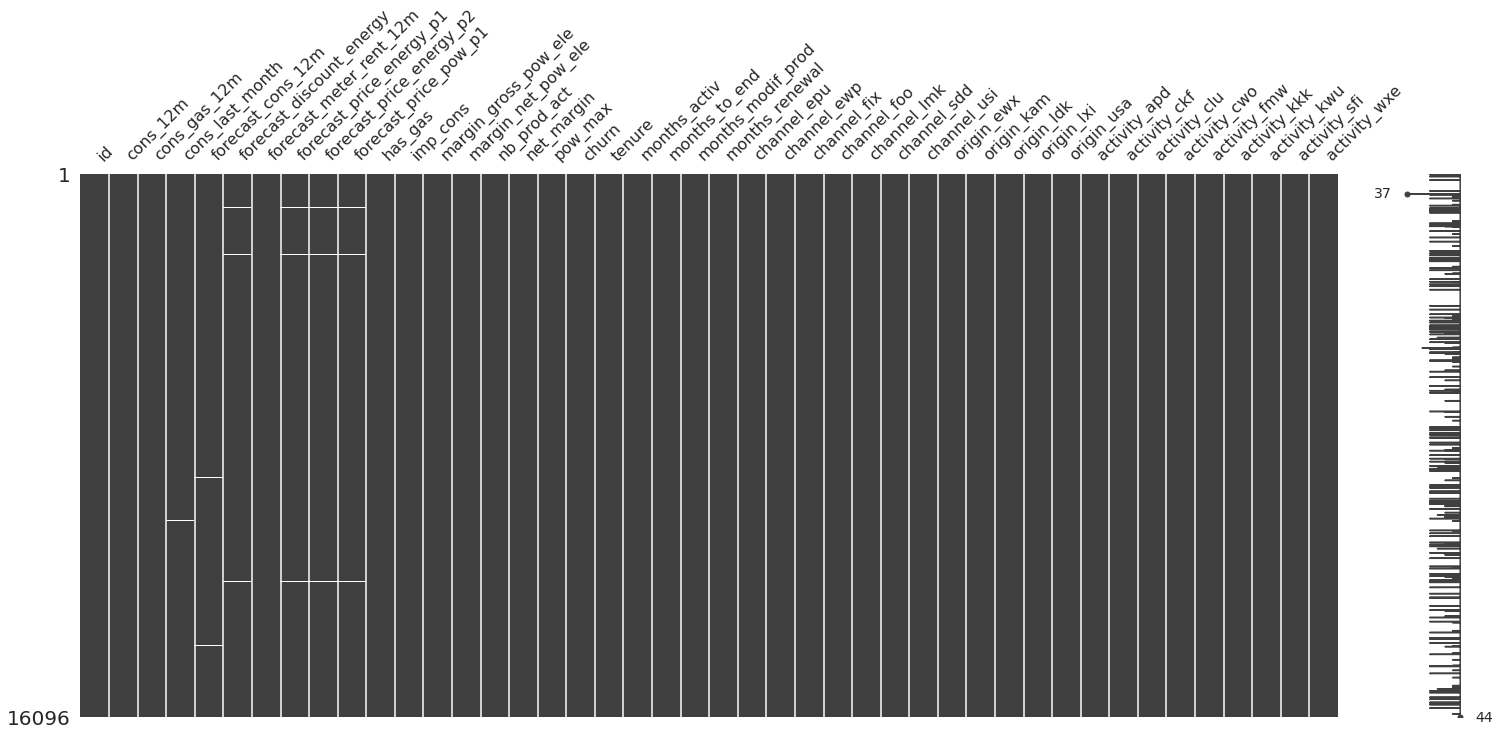

In [52]:
msno.matrix(train)

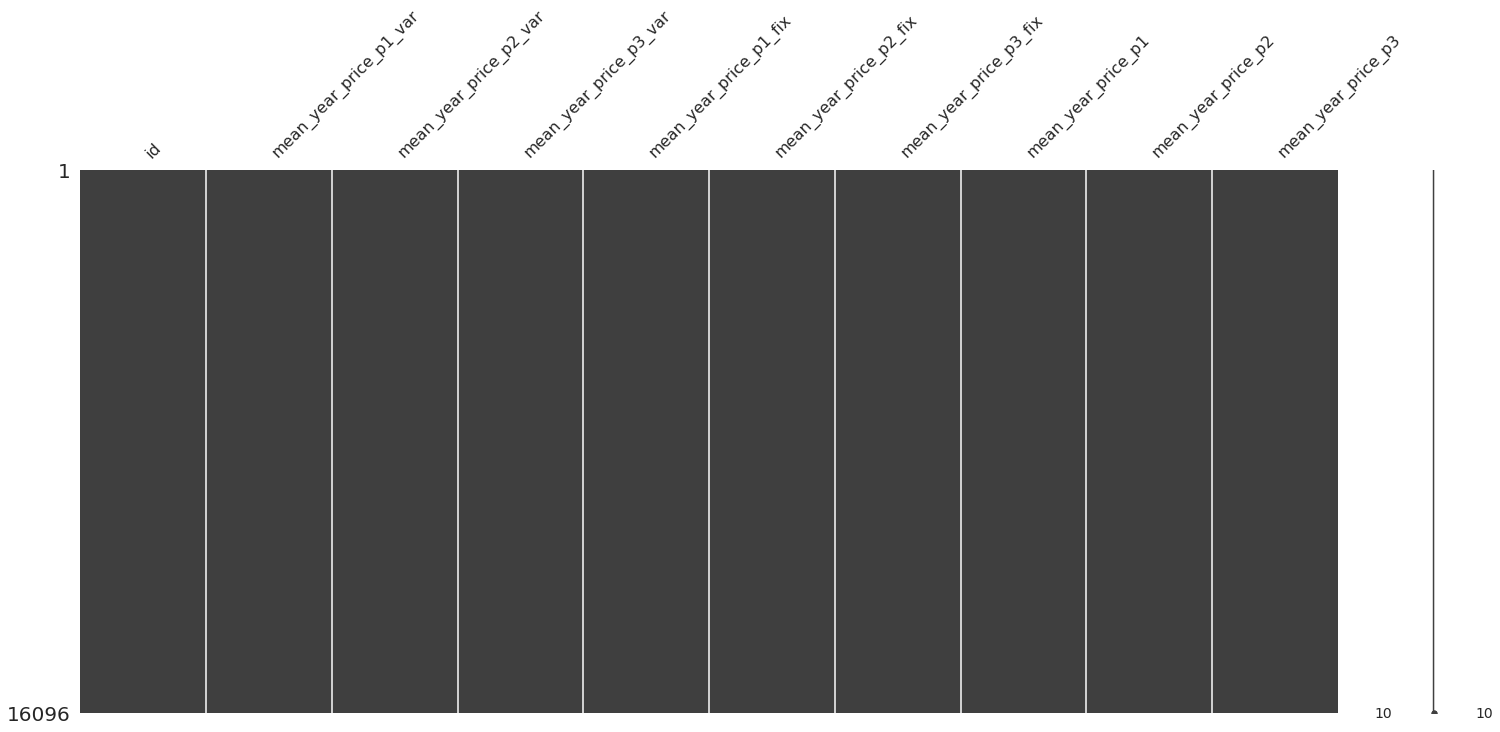

In [53]:
msno.matrix(features)

## Removing Outliers
as we identified during the exploratory phase, the consumption data has several outliers. We are going to remove those outliers.

**What are the criteria to identify an outlier**

The most common way to identify an outlier are:
> 1. Data point that falls outside of 1.5 times of an iterquartile range above the 3rd quartile and below the 1st quartile
> 2. Data point that falls outside of 3 standard deviations

Once, we have identified the outlier, **What do we do with the outliers?** <br>
There are several ways to handle with those outliers such as removing them (this works well for massive datasets) or replacing them with sensible data (works better when the dataset is not that big)<br>
We will replace the outliers with mean (average of the values excluding outliers).


As we identified during the exploratory phase, and when carrying out the `log transformation`, the dataset has several outliers.



In [54]:
def replace_outliers_z_score(dataframe, column, Z = 3):
    '''
    Replace outliers with the mean values using the Z score.
    Nan values are also replaced with the mean values
    
    Parameters
    ----------
    dataframe: pandas dataframe
        Contains the data where the outliers are to be found
    column: str
        Usually a string with the name of the column
        
    Returns
    -------
    Dataframe
        With ouotliers under the lower the above the upper bound removed
    '''
    from scipy.stats import zscore
    df = dataframe.copy(deep = True)
    df.dropna(inplace = True, subset = [column])
    
    # Calculate mean withuot outliers
    df['zscore'] = zscore(df[column])
    df.dropna(inplace = True, subset = [column])
    
    # Calculate mean without outliers
    df['zscore'] = zscore(df[column])
    mean_ = df[(df['zscore'] > -Z)&(df['zscore'] < Z)][column].mean()
    # Replace with mean values
    dataframe[column] = dataframe[column].fillna(mean_)
    dataframe['zscore'] = zscore(dataframe[column])
    no_outliers = dataframe[(dataframe['zscore'] < -Z)&(dataframe['zscore'] > Z)].shape[0]
    dataframe.loc[(dataframe['zscore'] < -Z)|(dataframe['zscore'] > Z), column] = mean_
    
    # print message
    print('Replaced:', no_outliers, 'outliers in ', column)
    return dataframe.drop(columns = 'zscore')

In [55]:
for c in features.columns:
    if c != 'id':
        features = replace_outliers_z_score(features, c)

Replaced: 0 outliers in  mean_year_price_p1_var
Replaced: 0 outliers in  mean_year_price_p2_var
Replaced: 0 outliers in  mean_year_price_p3_var
Replaced: 0 outliers in  mean_year_price_p1_fix
Replaced: 0 outliers in  mean_year_price_p2_fix
Replaced: 0 outliers in  mean_year_price_p3_fix
Replaced: 0 outliers in  mean_year_price_p1
Replaced: 0 outliers in  mean_year_price_p2
Replaced: 0 outliers in  mean_year_price_p3


In [56]:
features.reset_index(drop = True, inplace = True)

In [57]:
def _find_outliers_iqr(datarame, column):
    '''
    Find outliers using the 1.5*IQR rule
    
    Parameters
    ----------
    dataframe: pandas dataframe
        Contains the data where the outliers are to be found
    column: str
        Usually a string with the name of the column
    
    Returns
    -------
    Dict
        With the values of the IQR, lower_bound and upper_bound
    '''
    col = sorted(dataframe[column])
    q1, q3 = np.percentile(col, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5*iqr)
    upper_bound = q3 + (1.5*iqr)
    
    results = {'iqr': iqr,
              'lower_bound': lower_bound,
              'upper_bound': upper_bound}
    return results

def remove_outliers_iqr(dataframe, column):
    '''
    Remove outliers using the 1.5*IQR rule.
    
    Parameters
    ----------
    dataframe: pandas dataframe
        Contains the data where the outliers are to be found
    column: str
        Usually a string with the name of the column
        
    Returns
    -------
    DataFrame
        With outliers under the lower and above the upper bound removed
    '''
    outliers = _find_outliers_iqr(dataframe, column)
    removed = dataframe[(dataframe[column] < outliers['lower_bound'])|(dataframe[column] > outliers['upper_bound'])]\
    .shape
    dataframe = dataframe[(dataframe[column] > outliers['lower_bound'])&(dataframe[column] < outliers['upper_bound'])]
    print('Removed:', removed[0], 'outliers')
    return dataframe

def remove_outliers_z_score(dataframe, column, Z = 3):
    '''
    Remove outliers using the Z score. Values with more than 3 are removed.
    
    Parameters
    ----------
    dataframe: pandas dataframe
        Contains the data where the outliers are to be found
    column: str
        Usually a string with the name of the column
        
    Returns
    -------
    Dataframe
        With outliers under the lowerr and above the upper bound removed
    '''
    from scipy.stats import zscore
    
    dataframe['zscore'] = zscore(dataframe[column])
    
    removed = dataframe[(dataframe['zscore'] < -Z)|(dataframe['zscore'] > Z)]\
    .shape
    
    dataframe = dataframe[(dataframe['zscore'] > -Z)&(dataframe['zscore'] < Z)]
    print('Removed:', removed[0], 'outliers of ', column)
    return dataframe.drop(columns = 'zscore')

def replace_outliers_z_score(dataframe, column, Z = 3):
    '''
    Replace outliers with the mean values using the Z score.
    Nan values are also replaced with mean values.
    
    Parameters
    ----------
    dataframe: pandas dataframe
        Contains the data where the outliers are to be found
    column: str
        Usually a string with name of the column
        
    Returns
    -------
    Dataframe
        With outliers under the lower and above the upper bound removed
    '''
    from scipy.stats import zscore
    
    df = dataframe.copy(deep = True)
    df.dropna(inplace = True, subset = [column])
    # Calculate mean without uotliers
    df['zscore'] = zscore(df[column])
    mean_ = df[(df['zscore'] > -Z)&(df['zscore'] < Z)][column].mean()
    # Replace with mean values
    no_outliers = dataframe[column].isnull().sum() 
    dataframe[column] = dataframe[column].fillna(mean_)
    dataframe['zscore'] = zscore(dataframe[column])
    dataframe.loc[(dataframe['zscore'] < -Z)|(dataframe['zscore'] > Z), column] = mean_
    # print message
    print('Replaced:', no_outliers, ' outliers in ', column)
    return dataframe.drop(columns = 'zscore')


In [58]:
dummy_col = ['id', 'has_gas', 'nb_prod_act', 'churn', 'tenure', 'channel_epu',
       'channel_ewp', 'channel_fix', 'channel_foo', 'channel_lmk',
       'channel_sdd', 'channel_usi', 'origin_ewx', 'origin_kam', 'origin_ldk',
       'origin_lxi', 'origin_usa', 'activity_apd', 'activity_ckf',
       'activity_clu', 'activity_cwo', 'activity_fmw', 'activity_kkk',
       'activity_kwu', 'activity_sfi', 'activity_wxe']

for c in train.columns:
    if c not in dummy_col:
        train = replace_outliers_z_score(train, c)

Replaced: 27  outliers in  cons_12m
Replaced: 6  outliers in  cons_gas_12m
Replaced: 46  outliers in  cons_last_month
Replaced: 41  outliers in  forecast_cons_12m
Replaced: 126  outliers in  forecast_discount_energy
Replaced: 4  outliers in  forecast_meter_rent_12m
Replaced: 126  outliers in  forecast_price_energy_p1
Replaced: 126  outliers in  forecast_price_energy_p2
Replaced: 126  outliers in  forecast_price_pow_p1
Replaced: 27  outliers in  imp_cons
Replaced: 13  outliers in  margin_gross_pow_ele
Replaced: 13  outliers in  margin_net_pow_ele
Replaced: 15  outliers in  net_margin
Replaced: 3  outliers in  pow_max
Replaced: 0  outliers in  months_activ
Replaced: 0  outliers in  months_to_end
Replaced: 0  outliers in  months_modif_prod
Replaced: 0  outliers in  months_renewal


In [59]:
train.reset_index(drop = True, inplace = True)

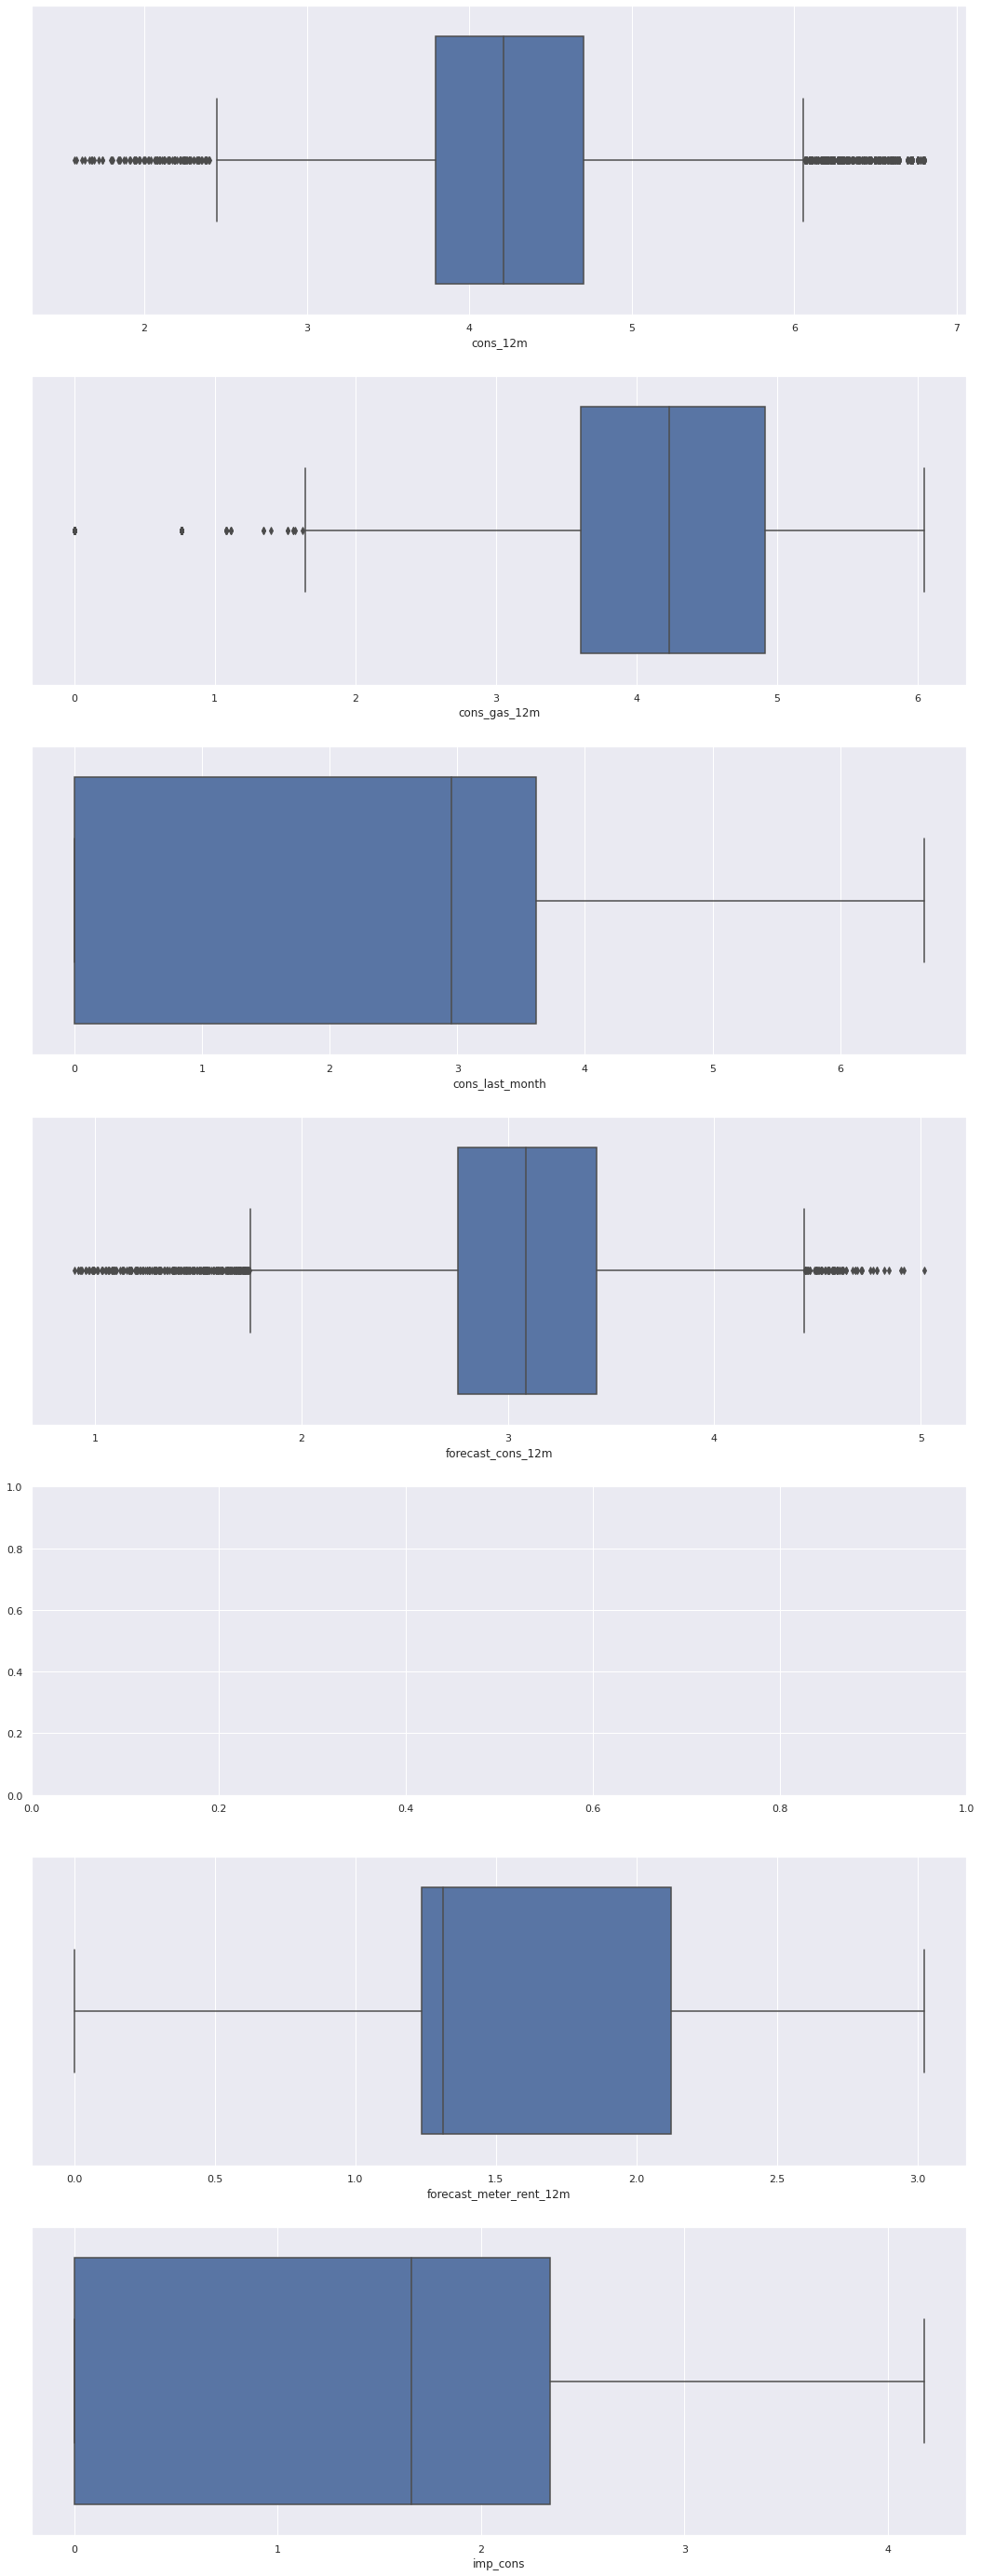

In [60]:
fig, axs = plt.subplots(nrows = 7, figsize = (18, 50));
# Plot Boxplot
sns.boxplot(x = train['cons_12m'].dropna(), ax = axs[0]);
sns.boxplot(x = train[train['has_gas'] == 1]['cons_gas_12m'].dropna(), ax = axs[1]);
sns.boxplot(x = train['cons_last_month'].dropna(), ax = axs[2]);
sns.boxplot(x = train['forecast_cons_12m'].dropna(), ax = axs[3]);
#sns.boxplot(x = train['forecast_cons_year'].dropna(), ax = axs[4]);
sns.boxplot(x = train['forecast_meter_rent_12m'].dropna(), ax = axs[5]);
sns.boxplot(x = train['imp_cons'].dropna(), ax = axs[6]);
plt.show()

In [61]:
train.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,churn,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
0,48ada52261e7cf58715202705a0451c9,5.490346,0.000000,4.001128,4.423595,0.0,2.556652,0.095919,0.088347,58.995952,0,2.920541,-41.76,-41.76,1,198.346424,18.402912,0,3,37.0,10.0,37.0,1.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,24011ae4ebbe3035111d65fa7c15bc57,4.327104,4.739944,0.000000,3.085953,0.0,0.444045,0.114481,0.098142,40.606701,1,0.000000,25.44,25.44,2,678.990000,43.648000,1,3,30.0,5.0,2.0,6.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,0,0.000000,16.38,16.38,1,18.890000,13.800000,0,7,76.0,7.0,76.0,4.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,0,0.000000,28.60,28.60,1,6.600000,13.856000,0,6,68.0,3.0,68.0,8.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,0,0.000000,30.22,30.22,1,25.460000,13.200000,0,6,69.0,2.0,69.0,9.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
features.head()

,id,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854
1,0004351ebdd665e6ee664792efc4fd13,0.146427,0.000000,0.000000,44.385450,0.000000,0.000000,44.531877,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,45.501268,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,40.766185,24.486748,16.328003
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,44.414856,0.000000,0.000000


## 4 Pickling
we will pickle the data so that we can easily retrieve it in for the next exercise


In [ ]:
PICKLE_TRAIN_DIR = os.path.join('..', 'BCG', 'processed_data', 'train_data.pkl')
PICKLE_HISTORY_DIR = os.path.join('..', 'BCG', 'processed_data', 'history_data.pkl')


In [ ]:
pd.to_pickle(train, PICKLE_TRAIN_DIR)
pd.to_pickle(features, PICKLE_HISTORY_DIR)